In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os
import joblib


In [6]:
data = joblib.load('data_with_features.joblib')
data

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126..."
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10..."
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096..."
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0...."
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0...."
...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737..."


In [7]:
# adding 1e-9 to prevent error when doing logarithm
# ??????
data['label'] = -np.log10(data['Raw Kd'] + 1e-9)

In [8]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [9]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)
total_dataset = MPI_Dataset(data)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
total_loader = DataLoader(total_dataset, batch_size=32, shuffle=False)

In [10]:
# cold splitting



In [11]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define MLP Model for Regression
class MLPRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim=1):
        super(MLPRegressor, self).__init__()

        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        
        # norm layer + Dropout
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)

        # hidden layer + output layer
        self.hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)

        self.activation = nn.ReLU()

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_embedding = self.activation(self.mol_encoder(mol_input))
        protein_embedding = self.activation(self.protein_encoder(protein_input))

        # Concatenate + Normalize + Dropout
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Hidden → Regress
        hidden_out = self.activation(self.hidden(combined))
        output = self.regressor(hidden_out)

        return output.squeeze(1)


In [12]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = MLPRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim,hidden_dim=512)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)

# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")


Training Epoch 1: 100%|██████████| 373/373 [00:03<00:00, 110.09it/s]


Epoch 0 - Train Loss: 2.0199, Train MSE: 2.0225, Train MAE: 1.1063
Epoch 0 - Validation Loss: 1.8891, Validation MSE: 1.8898, Validation MAE: 1.0530


/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_47105/3478497585.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)
Training Epoch 11: 100%|██████████| 373/373 [00:03<00:00, 113.48it/s]


Epoch 10 - Train Loss: 1.3453, Train MSE: 1.3434, Train MAE: 0.8844
Epoch 10 - Validation Loss: 1.4517, Validation MSE: 1.4541, Validation MAE: 0.9004


Training Epoch 21: 100%|██████████| 373/373 [00:02<00:00, 143.55it/s]


Epoch 20 - Train Loss: 1.0858, Train MSE: 1.0870, Train MAE: 0.7888
Epoch 20 - Validation Loss: 1.3049, Validation MSE: 1.3076, Validation MAE: 0.8299


Training Epoch 31: 100%|██████████| 373/373 [00:03<00:00, 112.45it/s]


Epoch 30 - Train Loss: 0.9688, Train MSE: 0.9686, Train MAE: 0.7402
Epoch 30 - Validation Loss: 1.2380, Validation MSE: 1.2410, Validation MAE: 0.8003


Training Epoch 41: 100%|██████████| 373/373 [00:02<00:00, 131.63it/s]


Epoch 40 - Train Loss: 0.8742, Train MSE: 0.8709, Train MAE: 0.6981
Epoch 40 - Validation Loss: 1.2035, Validation MSE: 1.2062, Validation MAE: 0.7799


Training Epoch 51: 100%|██████████| 373/373 [00:03<00:00, 122.43it/s]


Epoch 50 - Train Loss: 0.8197, Train MSE: 0.8193, Train MAE: 0.6701
Epoch 50 - Validation Loss: 1.2110, Validation MSE: 1.2139, Validation MAE: 0.7851


Training Epoch 61: 100%|██████████| 373/373 [00:02<00:00, 145.49it/s]


Epoch 60 - Train Loss: 0.7623, Train MSE: 0.7625, Train MAE: 0.6404
Epoch 60 - Validation Loss: 1.1952, Validation MSE: 1.1977, Validation MAE: 0.7685


Training Epoch 71: 100%|██████████| 373/373 [00:02<00:00, 129.30it/s]


Epoch 70 - Train Loss: 0.7363, Train MSE: 0.7331, Train MAE: 0.6255
Epoch 70 - Validation Loss: 1.1908, Validation MSE: 1.1936, Validation MAE: 0.7741


Training Epoch 81: 100%|██████████| 373/373 [00:02<00:00, 128.80it/s]


Epoch 80 - Train Loss: 0.7119, Train MSE: 0.7136, Train MAE: 0.6166
Epoch 80 - Validation Loss: 1.1877, Validation MSE: 1.1904, Validation MAE: 0.7626


Training Epoch 91: 100%|██████████| 373/373 [00:02<00:00, 130.12it/s]


Epoch 90 - Train Loss: 0.6748, Train MSE: 0.6749, Train MAE: 0.5959
Epoch 90 - Validation Loss: 1.1936, Validation MSE: 1.1960, Validation MAE: 0.7641


Training Epoch 101: 100%|██████████| 373/373 [00:02<00:00, 141.47it/s]


Epoch 100 - Train Loss: 0.6552, Train MSE: 0.6565, Train MAE: 0.5858
Epoch 100 - Validation Loss: 1.1962, Validation MSE: 1.1988, Validation MAE: 0.7618


Training Epoch 111: 100%|██████████| 373/373 [00:02<00:00, 129.09it/s]


Epoch 110 - Train Loss: 0.6441, Train MSE: 0.6431, Train MAE: 0.5788
Epoch 110 - Validation Loss: 1.2142, Validation MSE: 1.2167, Validation MAE: 0.7821


Training Epoch 121: 100%|██████████| 373/373 [00:02<00:00, 127.85it/s]


Epoch 120 - Train Loss: 0.6369, Train MSE: 0.6379, Train MAE: 0.5740
Epoch 120 - Validation Loss: 1.1787, Validation MSE: 1.1812, Validation MAE: 0.7546


Training Epoch 131: 100%|██████████| 373/373 [00:02<00:00, 134.68it/s]


Epoch 130 - Train Loss: 0.6164, Train MSE: 0.6176, Train MAE: 0.5616
Epoch 130 - Validation Loss: 1.1909, Validation MSE: 1.1935, Validation MAE: 0.7569


Training Epoch 141: 100%|██████████| 373/373 [00:02<00:00, 133.55it/s]


Epoch 140 - Train Loss: 0.6071, Train MSE: 0.6084, Train MAE: 0.5545
Epoch 140 - Validation Loss: 1.2033, Validation MSE: 1.2053, Validation MAE: 0.7621


Training Epoch 151: 100%|██████████| 373/373 [00:03<00:00, 123.43it/s]


Epoch 150 - Train Loss: 0.5948, Train MSE: 0.5930, Train MAE: 0.5481
Epoch 150 - Validation Loss: 1.1954, Validation MSE: 1.1980, Validation MAE: 0.7541


Training Epoch 161: 100%|██████████| 373/373 [00:02<00:00, 130.70it/s]


Epoch 160 - Train Loss: 0.5783, Train MSE: 0.5796, Train MAE: 0.5400
Epoch 160 - Validation Loss: 1.2105, Validation MSE: 1.2130, Validation MAE: 0.7641


Training Epoch 171: 100%|██████████| 373/373 [00:03<00:00, 117.17it/s]


Epoch 170 - Train Loss: 0.5732, Train MSE: 0.5733, Train MAE: 0.5353
Epoch 170 - Validation Loss: 1.2073, Validation MSE: 1.2100, Validation MAE: 0.7620


Training Epoch 181: 100%|██████████| 373/373 [00:02<00:00, 124.64it/s]


Epoch 180 - Train Loss: 0.5720, Train MSE: 0.5711, Train MAE: 0.5313
Epoch 180 - Validation Loss: 1.2293, Validation MSE: 1.2320, Validation MAE: 0.7694


Training Epoch 191: 100%|██████████| 373/373 [00:02<00:00, 130.78it/s]


Epoch 190 - Train Loss: 0.5590, Train MSE: 0.5586, Train MAE: 0.5282
Epoch 190 - Validation Loss: 1.2024, Validation MSE: 1.2047, Validation MAE: 0.7544


Training Epoch 201: 100%|██████████| 373/373 [00:02<00:00, 135.66it/s]


Epoch 200 - Train Loss: 0.5525, Train MSE: 0.5528, Train MAE: 0.5223
Epoch 200 - Validation Loss: 1.2097, Validation MSE: 1.2121, Validation MAE: 0.7662


Training Epoch 211: 100%|██████████| 373/373 [00:02<00:00, 128.34it/s]


Epoch 210 - Train Loss: 0.5454, Train MSE: 0.5448, Train MAE: 0.5171
Epoch 210 - Validation Loss: 1.1977, Validation MSE: 1.2002, Validation MAE: 0.7571


Training Epoch 221: 100%|██████████| 373/373 [00:02<00:00, 139.05it/s]


Epoch 220 - Train Loss: 0.5433, Train MSE: 0.5445, Train MAE: 0.5168
Epoch 220 - Validation Loss: 1.1923, Validation MSE: 1.1948, Validation MAE: 0.7500


Training Epoch 231: 100%|██████████| 373/373 [00:02<00:00, 131.20it/s]


Epoch 230 - Train Loss: 0.5451, Train MSE: 0.5427, Train MAE: 0.5162
Epoch 230 - Validation Loss: 1.1887, Validation MSE: 1.1909, Validation MAE: 0.7473


Training Epoch 241: 100%|██████████| 373/373 [00:04<00:00, 85.03it/s] 


Epoch 240 - Train Loss: 0.5281, Train MSE: 0.5289, Train MAE: 0.5055
Epoch 240 - Validation Loss: 1.2008, Validation MSE: 1.2026, Validation MAE: 0.7594


Training Epoch 251: 100%|██████████| 373/373 [00:03<00:00, 106.41it/s]


Epoch 250 - Train Loss: 0.5285, Train MSE: 0.5294, Train MAE: 0.5058
Epoch 250 - Validation Loss: 1.1899, Validation MSE: 1.1921, Validation MAE: 0.7503


Training Epoch 261: 100%|██████████| 373/373 [00:03<00:00, 109.27it/s]


Epoch 260 - Train Loss: 0.5253, Train MSE: 0.5265, Train MAE: 0.5047
Epoch 260 - Validation Loss: 1.2067, Validation MSE: 1.2094, Validation MAE: 0.7570


Training Epoch 271: 100%|██████████| 373/373 [00:04<00:00, 78.89it/s]


Epoch 270 - Train Loss: 0.5207, Train MSE: 0.5216, Train MAE: 0.5015
Epoch 270 - Validation Loss: 1.1955, Validation MSE: 1.1978, Validation MAE: 0.7611


Training Epoch 281: 100%|██████████| 373/373 [00:03<00:00, 103.47it/s]


Epoch 280 - Train Loss: 0.5241, Train MSE: 0.5253, Train MAE: 0.4974
Epoch 280 - Validation Loss: 1.2021, Validation MSE: 1.2045, Validation MAE: 0.7498


Training Epoch 291: 100%|██████████| 373/373 [00:02<00:00, 134.52it/s]


Epoch 290 - Train Loss: 0.5175, Train MSE: 0.5157, Train MAE: 0.4944
Epoch 290 - Validation Loss: 1.2010, Validation MSE: 1.2036, Validation MAE: 0.7541


Training Epoch 301: 100%|██████████| 373/373 [00:03<00:00, 107.54it/s]


Epoch 300 - Train Loss: 0.5115, Train MSE: 0.5126, Train MAE: 0.4928
Epoch 300 - Validation Loss: 1.2014, Validation MSE: 1.2033, Validation MAE: 0.7497


Training Epoch 311: 100%|██████████| 373/373 [00:02<00:00, 129.33it/s]


Epoch 310 - Train Loss: 0.5074, Train MSE: 0.5084, Train MAE: 0.4922
Epoch 310 - Validation Loss: 1.1991, Validation MSE: 1.2014, Validation MAE: 0.7519


Training Epoch 321: 100%|██████████| 373/373 [00:02<00:00, 134.67it/s]


Epoch 320 - Train Loss: 0.5038, Train MSE: 0.5042, Train MAE: 0.4878
Epoch 320 - Validation Loss: 1.1949, Validation MSE: 1.1972, Validation MAE: 0.7512


Training Epoch 331: 100%|██████████| 373/373 [00:03<00:00, 118.26it/s]


Epoch 330 - Train Loss: 0.5023, Train MSE: 0.5029, Train MAE: 0.4872
Epoch 330 - Validation Loss: 1.2057, Validation MSE: 1.2078, Validation MAE: 0.7603


Training Epoch 341: 100%|██████████| 373/373 [00:02<00:00, 145.29it/s]


Epoch 340 - Train Loss: 0.4976, Train MSE: 0.4980, Train MAE: 0.4843
Epoch 340 - Validation Loss: 1.2053, Validation MSE: 1.2074, Validation MAE: 0.7551


Training Epoch 351: 100%|██████████| 373/373 [00:02<00:00, 136.89it/s]


Epoch 350 - Train Loss: 0.5028, Train MSE: 0.5039, Train MAE: 0.4853
Epoch 350 - Validation Loss: 1.1900, Validation MSE: 1.1922, Validation MAE: 0.7461


Training Epoch 361: 100%|██████████| 373/373 [00:02<00:00, 140.38it/s]


Epoch 360 - Train Loss: 0.4965, Train MSE: 0.4970, Train MAE: 0.4805
Epoch 360 - Validation Loss: 1.1852, Validation MSE: 1.1874, Validation MAE: 0.7457


Training Epoch 371: 100%|██████████| 373/373 [00:02<00:00, 149.45it/s]


Epoch 370 - Train Loss: 0.4844, Train MSE: 0.4849, Train MAE: 0.4740
Epoch 370 - Validation Loss: 1.1941, Validation MSE: 1.1962, Validation MAE: 0.7509


Training Epoch 381: 100%|██████████| 373/373 [00:02<00:00, 144.05it/s]


Epoch 380 - Train Loss: 0.4881, Train MSE: 0.4885, Train MAE: 0.4764
Epoch 380 - Validation Loss: 1.2034, Validation MSE: 1.2055, Validation MAE: 0.7474


Training Epoch 391: 100%|██████████| 373/373 [00:02<00:00, 139.17it/s]


Epoch 390 - Train Loss: 0.4846, Train MSE: 0.4852, Train MAE: 0.4748
Epoch 390 - Validation Loss: 1.2021, Validation MSE: 1.2042, Validation MAE: 0.7568


Training Epoch 401: 100%|██████████| 373/373 [00:02<00:00, 137.47it/s]


Epoch 400 - Train Loss: 0.4744, Train MSE: 0.4754, Train MAE: 0.4670
Epoch 400 - Validation Loss: 1.1915, Validation MSE: 1.1936, Validation MAE: 0.7457


Training Epoch 411: 100%|██████████| 373/373 [00:02<00:00, 142.09it/s]


Epoch 410 - Train Loss: 0.4776, Train MSE: 0.4785, Train MAE: 0.4723
Epoch 410 - Validation Loss: 1.1992, Validation MSE: 1.2016, Validation MAE: 0.7485


Training Epoch 421: 100%|██████████| 373/373 [00:02<00:00, 143.06it/s]


Epoch 420 - Train Loss: 0.4824, Train MSE: 0.4833, Train MAE: 0.4742
Epoch 420 - Validation Loss: 1.2067, Validation MSE: 1.2087, Validation MAE: 0.7493


Training Epoch 431: 100%|██████████| 373/373 [00:02<00:00, 141.51it/s]


Epoch 430 - Train Loss: 0.4696, Train MSE: 0.4706, Train MAE: 0.4646
Epoch 430 - Validation Loss: 1.2013, Validation MSE: 1.2036, Validation MAE: 0.7537


Training Epoch 441: 100%|██████████| 373/373 [00:02<00:00, 142.09it/s]


Epoch 440 - Train Loss: 0.4667, Train MSE: 0.4674, Train MAE: 0.4617
Epoch 440 - Validation Loss: 1.2089, Validation MSE: 1.2114, Validation MAE: 0.7533


Training Epoch 451: 100%|██████████| 373/373 [00:02<00:00, 148.34it/s]


Epoch 450 - Train Loss: 0.4752, Train MSE: 0.4751, Train MAE: 0.4663
Epoch 450 - Validation Loss: 1.2006, Validation MSE: 1.2027, Validation MAE: 0.7515


Training Epoch 461: 100%|██████████| 373/373 [00:02<00:00, 137.82it/s]


Epoch 460 - Train Loss: 0.4655, Train MSE: 0.4656, Train MAE: 0.4636
Epoch 460 - Validation Loss: 1.2010, Validation MSE: 1.2030, Validation MAE: 0.7496


Training Epoch 471: 100%|██████████| 373/373 [00:02<00:00, 144.81it/s]


Epoch 470 - Train Loss: 0.4660, Train MSE: 0.4650, Train MAE: 0.4628
Epoch 470 - Validation Loss: 1.1973, Validation MSE: 1.1997, Validation MAE: 0.7487


Training Epoch 481: 100%|██████████| 373/373 [00:02<00:00, 129.54it/s]


Epoch 480 - Train Loss: 0.4610, Train MSE: 0.4616, Train MAE: 0.4569
Epoch 480 - Validation Loss: 1.1993, Validation MSE: 1.2015, Validation MAE: 0.7482


Training Epoch 491: 100%|██████████| 373/373 [00:02<00:00, 149.41it/s]


Epoch 490 - Train Loss: 0.4591, Train MSE: 0.4585, Train MAE: 0.4569
Epoch 490 - Validation Loss: 1.1892, Validation MSE: 1.1912, Validation MAE: 0.7439


Training Epoch 501: 100%|██████████| 373/373 [00:02<00:00, 152.69it/s]


Epoch 500 - Train Loss: 0.4578, Train MSE: 0.4586, Train MAE: 0.4559
Epoch 500 - Validation Loss: 1.2002, Validation MSE: 1.2021, Validation MAE: 0.7555


Training Epoch 511: 100%|██████████| 373/373 [00:08<00:00, 42.07it/s]


Epoch 510 - Train Loss: 0.4644, Train MSE: 0.4651, Train MAE: 0.4590
Epoch 510 - Validation Loss: 1.2141, Validation MSE: 1.2161, Validation MAE: 0.7541


Training Epoch 521: 100%|██████████| 373/373 [00:01<00:00, 204.41it/s]


Epoch 520 - Train Loss: 0.4596, Train MSE: 0.4606, Train MAE: 0.4557
Epoch 520 - Validation Loss: 1.1996, Validation MSE: 1.2018, Validation MAE: 0.7463


Training Epoch 531: 100%|██████████| 373/373 [00:01<00:00, 200.18it/s]


Epoch 530 - Train Loss: 0.4528, Train MSE: 0.4534, Train MAE: 0.4512
Epoch 530 - Validation Loss: 1.2040, Validation MSE: 1.2063, Validation MAE: 0.7470


Training Epoch 541: 100%|██████████| 373/373 [00:01<00:00, 199.91it/s]


Epoch 540 - Train Loss: 0.4545, Train MSE: 0.4554, Train MAE: 0.4539
Epoch 540 - Validation Loss: 1.1904, Validation MSE: 1.1924, Validation MAE: 0.7451


Training Epoch 551: 100%|██████████| 373/373 [00:01<00:00, 196.79it/s]


Epoch 550 - Train Loss: 0.4467, Train MSE: 0.4478, Train MAE: 0.4492
Epoch 550 - Validation Loss: 1.2137, Validation MSE: 1.2156, Validation MAE: 0.7540


Training Epoch 561: 100%|██████████| 373/373 [00:01<00:00, 203.80it/s]


Epoch 560 - Train Loss: 0.4460, Train MSE: 0.4435, Train MAE: 0.4466
Epoch 560 - Validation Loss: 1.1905, Validation MSE: 1.1926, Validation MAE: 0.7404


Training Epoch 571: 100%|██████████| 373/373 [00:01<00:00, 203.63it/s]


Epoch 570 - Train Loss: 0.4505, Train MSE: 0.4503, Train MAE: 0.4508
Epoch 570 - Validation Loss: 1.2142, Validation MSE: 1.2165, Validation MAE: 0.7497


Training Epoch 581: 100%|██████████| 373/373 [00:01<00:00, 189.90it/s]


Epoch 580 - Train Loss: 0.4491, Train MSE: 0.4502, Train MAE: 0.4516
Epoch 580 - Validation Loss: 1.2073, Validation MSE: 1.2091, Validation MAE: 0.7470


Training Epoch 591: 100%|██████████| 373/373 [00:01<00:00, 198.85it/s]


Epoch 590 - Train Loss: 0.4450, Train MSE: 0.4457, Train MAE: 0.4473
Epoch 590 - Validation Loss: 1.1910, Validation MSE: 1.1934, Validation MAE: 0.7435


Training Epoch 601: 100%|██████████| 373/373 [00:01<00:00, 202.50it/s]


Epoch 600 - Train Loss: 0.4353, Train MSE: 0.4363, Train MAE: 0.4425
Epoch 600 - Validation Loss: 1.1945, Validation MSE: 1.1965, Validation MAE: 0.7482


Training Epoch 611: 100%|██████████| 373/373 [00:01<00:00, 203.12it/s]


Epoch 610 - Train Loss: 0.4455, Train MSE: 0.4463, Train MAE: 0.4462
Epoch 610 - Validation Loss: 1.2089, Validation MSE: 1.2114, Validation MAE: 0.7484


Training Epoch 621: 100%|██████████| 373/373 [00:01<00:00, 206.64it/s]


Epoch 620 - Train Loss: 0.4369, Train MSE: 0.4378, Train MAE: 0.4447
Epoch 620 - Validation Loss: 1.1942, Validation MSE: 1.1960, Validation MAE: 0.7481


Training Epoch 631: 100%|██████████| 373/373 [00:01<00:00, 197.24it/s]


Epoch 630 - Train Loss: 0.4367, Train MSE: 0.4376, Train MAE: 0.4436
Epoch 630 - Validation Loss: 1.2078, Validation MSE: 1.2099, Validation MAE: 0.7509


Training Epoch 641: 100%|██████████| 373/373 [00:02<00:00, 180.77it/s]


Epoch 640 - Train Loss: 0.4399, Train MSE: 0.4344, Train MAE: 0.4382
Epoch 640 - Validation Loss: 1.2228, Validation MSE: 1.2249, Validation MAE: 0.7531


Training Epoch 651: 100%|██████████| 373/373 [00:01<00:00, 195.84it/s]


Epoch 650 - Train Loss: 0.4330, Train MSE: 0.4334, Train MAE: 0.4378
Epoch 650 - Validation Loss: 1.1923, Validation MSE: 1.1941, Validation MAE: 0.7469


Training Epoch 661: 100%|██████████| 373/373 [00:01<00:00, 197.09it/s]


Epoch 660 - Train Loss: 0.4294, Train MSE: 0.4303, Train MAE: 0.4373
Epoch 660 - Validation Loss: 1.2073, Validation MSE: 1.2091, Validation MAE: 0.7446


Training Epoch 671: 100%|██████████| 373/373 [00:01<00:00, 191.76it/s]


Epoch 670 - Train Loss: 0.4393, Train MSE: 0.4398, Train MAE: 0.4424
Epoch 670 - Validation Loss: 1.2200, Validation MSE: 1.2217, Validation MAE: 0.7525


Training Epoch 681: 100%|██████████| 373/373 [00:01<00:00, 189.95it/s]


Epoch 680 - Train Loss: 0.4326, Train MSE: 0.4317, Train MAE: 0.4371
Epoch 680 - Validation Loss: 1.2100, Validation MSE: 1.2123, Validation MAE: 0.7490


Training Epoch 691: 100%|██████████| 373/373 [00:01<00:00, 187.08it/s]


Epoch 690 - Train Loss: 0.4309, Train MSE: 0.4309, Train MAE: 0.4371
Epoch 690 - Validation Loss: 1.1882, Validation MSE: 1.1904, Validation MAE: 0.7427


Training Epoch 701: 100%|██████████| 373/373 [00:01<00:00, 190.94it/s]


Epoch 700 - Train Loss: 0.4300, Train MSE: 0.4299, Train MAE: 0.4405
Epoch 700 - Validation Loss: 1.1897, Validation MSE: 1.1921, Validation MAE: 0.7410


Training Epoch 711: 100%|██████████| 373/373 [00:01<00:00, 191.36it/s]


Epoch 710 - Train Loss: 0.4207, Train MSE: 0.4206, Train MAE: 0.4307
Epoch 710 - Validation Loss: 1.2330, Validation MSE: 1.2349, Validation MAE: 0.7569


Training Epoch 721: 100%|██████████| 373/373 [00:02<00:00, 185.87it/s]


Epoch 720 - Train Loss: 0.4298, Train MSE: 0.4297, Train MAE: 0.4367
Epoch 720 - Validation Loss: 1.1845, Validation MSE: 1.1865, Validation MAE: 0.7349


Training Epoch 731: 100%|██████████| 373/373 [00:02<00:00, 185.60it/s]


Epoch 730 - Train Loss: 0.4215, Train MSE: 0.4224, Train MAE: 0.4342
Epoch 730 - Validation Loss: 1.2070, Validation MSE: 1.2093, Validation MAE: 0.7485


Training Epoch 741: 100%|██████████| 373/373 [00:01<00:00, 196.04it/s]


Epoch 740 - Train Loss: 0.4174, Train MSE: 0.4183, Train MAE: 0.4301
Epoch 740 - Validation Loss: 1.2082, Validation MSE: 1.2102, Validation MAE: 0.7473


Training Epoch 751: 100%|██████████| 373/373 [00:01<00:00, 192.46it/s]


Epoch 750 - Train Loss: 0.4240, Train MSE: 0.4239, Train MAE: 0.4326
Epoch 750 - Validation Loss: 1.2083, Validation MSE: 1.2101, Validation MAE: 0.7464


Training Epoch 761: 100%|██████████| 373/373 [00:02<00:00, 186.00it/s]


Epoch 760 - Train Loss: 0.4185, Train MSE: 0.4184, Train MAE: 0.4295
Epoch 760 - Validation Loss: 1.2036, Validation MSE: 1.2059, Validation MAE: 0.7447


Training Epoch 771: 100%|██████████| 373/373 [00:01<00:00, 189.91it/s]


Epoch 770 - Train Loss: 0.4177, Train MSE: 0.4180, Train MAE: 0.4311
Epoch 770 - Validation Loss: 1.2394, Validation MSE: 1.2416, Validation MAE: 0.7593


Training Epoch 781: 100%|██████████| 373/373 [00:02<00:00, 185.18it/s]


Epoch 780 - Train Loss: 0.4100, Train MSE: 0.4110, Train MAE: 0.4239
Epoch 780 - Validation Loss: 1.1988, Validation MSE: 1.2008, Validation MAE: 0.7425


Training Epoch 791: 100%|██████████| 373/373 [00:02<00:00, 179.19it/s]


Epoch 790 - Train Loss: 0.4193, Train MSE: 0.4199, Train MAE: 0.4292
Epoch 790 - Validation Loss: 1.1940, Validation MSE: 1.1959, Validation MAE: 0.7377


Training Epoch 801: 100%|██████████| 373/373 [00:01<00:00, 189.97it/s]


Epoch 800 - Train Loss: 0.4188, Train MSE: 0.4176, Train MAE: 0.4287
Epoch 800 - Validation Loss: 1.2127, Validation MSE: 1.2145, Validation MAE: 0.7453


Training Epoch 811: 100%|██████████| 373/373 [00:02<00:00, 182.06it/s]


Epoch 810 - Train Loss: 0.4148, Train MSE: 0.4150, Train MAE: 0.4258
Epoch 810 - Validation Loss: 1.1943, Validation MSE: 1.1966, Validation MAE: 0.7343


Training Epoch 821: 100%|██████████| 373/373 [00:01<00:00, 189.17it/s]


Epoch 820 - Train Loss: 0.4104, Train MSE: 0.4109, Train MAE: 0.4244
Epoch 820 - Validation Loss: 1.1963, Validation MSE: 1.1984, Validation MAE: 0.7392


Training Epoch 831: 100%|██████████| 373/373 [00:02<00:00, 183.78it/s]


Epoch 830 - Train Loss: 0.4103, Train MSE: 0.4110, Train MAE: 0.4235
Epoch 830 - Validation Loss: 1.2114, Validation MSE: 1.2134, Validation MAE: 0.7513


Training Epoch 841: 100%|██████████| 373/373 [00:01<00:00, 189.88it/s]


Epoch 840 - Train Loss: 0.4116, Train MSE: 0.4114, Train MAE: 0.4251
Epoch 840 - Validation Loss: 1.1985, Validation MSE: 1.2005, Validation MAE: 0.7438


Training Epoch 851: 100%|██████████| 373/373 [00:02<00:00, 184.33it/s]


Epoch 850 - Train Loss: 0.4096, Train MSE: 0.4102, Train MAE: 0.4251
Epoch 850 - Validation Loss: 1.2125, Validation MSE: 1.2144, Validation MAE: 0.7435


Training Epoch 861: 100%|██████████| 373/373 [00:01<00:00, 187.05it/s]


Epoch 860 - Train Loss: 0.4059, Train MSE: 0.4060, Train MAE: 0.4189
Epoch 860 - Validation Loss: 1.1995, Validation MSE: 1.2010, Validation MAE: 0.7418


Training Epoch 871: 100%|██████████| 373/373 [00:02<00:00, 185.74it/s]


Epoch 870 - Train Loss: 0.4086, Train MSE: 0.4088, Train MAE: 0.4226
Epoch 870 - Validation Loss: 1.1927, Validation MSE: 1.1946, Validation MAE: 0.7396


Training Epoch 881: 100%|██████████| 373/373 [00:01<00:00, 188.42it/s]


Epoch 880 - Train Loss: 0.4056, Train MSE: 0.4065, Train MAE: 0.4213
Epoch 880 - Validation Loss: 1.2039, Validation MSE: 1.2058, Validation MAE: 0.7432


Training Epoch 891: 100%|██████████| 373/373 [00:02<00:00, 179.14it/s]


Epoch 890 - Train Loss: 0.4066, Train MSE: 0.4076, Train MAE: 0.4234
Epoch 890 - Validation Loss: 1.1976, Validation MSE: 1.1996, Validation MAE: 0.7373


Training Epoch 901: 100%|██████████| 373/373 [00:01<00:00, 188.45it/s]


Epoch 900 - Train Loss: 0.3974, Train MSE: 0.3979, Train MAE: 0.4162
Epoch 900 - Validation Loss: 1.2136, Validation MSE: 1.2156, Validation MAE: 0.7411


Training Epoch 911: 100%|██████████| 373/373 [00:02<00:00, 185.57it/s]


Epoch 910 - Train Loss: 0.4023, Train MSE: 0.4024, Train MAE: 0.4167
Epoch 910 - Validation Loss: 1.1964, Validation MSE: 1.1987, Validation MAE: 0.7342


Training Epoch 921: 100%|██████████| 373/373 [00:02<00:00, 182.19it/s]


Epoch 920 - Train Loss: 0.4037, Train MSE: 0.4043, Train MAE: 0.4190
Epoch 920 - Validation Loss: 1.2079, Validation MSE: 1.2099, Validation MAE: 0.7419


Training Epoch 931: 100%|██████████| 373/373 [00:01<00:00, 190.61it/s]


Epoch 930 - Train Loss: 0.4043, Train MSE: 0.4031, Train MAE: 0.4196
Epoch 930 - Validation Loss: 1.2100, Validation MSE: 1.2120, Validation MAE: 0.7480


Training Epoch 941: 100%|██████████| 373/373 [00:01<00:00, 188.76it/s]


Epoch 940 - Train Loss: 0.3949, Train MSE: 0.3959, Train MAE: 0.4160
Epoch 940 - Validation Loss: 1.2092, Validation MSE: 1.2110, Validation MAE: 0.7521


Training Epoch 951: 100%|██████████| 373/373 [00:02<00:00, 183.40it/s]


Epoch 950 - Train Loss: 0.4002, Train MSE: 0.4010, Train MAE: 0.4166
Epoch 950 - Validation Loss: 1.1966, Validation MSE: 1.1986, Validation MAE: 0.7383


Training Epoch 961: 100%|██████████| 373/373 [00:01<00:00, 186.90it/s]


Epoch 960 - Train Loss: 0.3958, Train MSE: 0.3961, Train MAE: 0.4162
Epoch 960 - Validation Loss: 1.1851, Validation MSE: 1.1875, Validation MAE: 0.7338


Training Epoch 971: 100%|██████████| 373/373 [00:01<00:00, 186.57it/s]


Epoch 970 - Train Loss: 0.3982, Train MSE: 0.3984, Train MAE: 0.4163
Epoch 970 - Validation Loss: 1.1991, Validation MSE: 1.2011, Validation MAE: 0.7415


Training Epoch 981: 100%|██████████| 373/373 [00:01<00:00, 187.46it/s]


Epoch 980 - Train Loss: 0.4009, Train MSE: 0.4011, Train MAE: 0.4190
Epoch 980 - Validation Loss: 1.1887, Validation MSE: 1.1905, Validation MAE: 0.7368


Training Epoch 991: 100%|██████████| 373/373 [00:01<00:00, 186.93it/s]


Epoch 990 - Train Loss: 0.4005, Train MSE: 0.4001, Train MAE: 0.4149
Epoch 990 - Validation Loss: 1.1922, Validation MSE: 1.1941, Validation MAE: 0.7405


Training Epoch 1001: 100%|██████████| 373/373 [00:02<00:00, 180.54it/s]


Epoch 1000 - Train Loss: 0.3889, Train MSE: 0.3896, Train MAE: 0.4083
Epoch 1000 - Validation Loss: 1.1972, Validation MSE: 1.1989, Validation MAE: 0.7399


Training Epoch 1011: 100%|██████████| 373/373 [00:01<00:00, 191.68it/s]


Epoch 1010 - Train Loss: 0.3907, Train MSE: 0.3909, Train MAE: 0.4102
Epoch 1010 - Validation Loss: 1.1921, Validation MSE: 1.1939, Validation MAE: 0.7400


Training Epoch 1021: 100%|██████████| 373/373 [00:02<00:00, 182.79it/s]


Epoch 1020 - Train Loss: 0.4004, Train MSE: 0.3954, Train MAE: 0.4144
Epoch 1020 - Validation Loss: 1.1934, Validation MSE: 1.1954, Validation MAE: 0.7415


Training Epoch 1031: 100%|██████████| 373/373 [00:02<00:00, 179.22it/s]


Epoch 1030 - Train Loss: 0.3943, Train MSE: 0.3952, Train MAE: 0.4123
Epoch 1030 - Validation Loss: 1.1997, Validation MSE: 1.2015, Validation MAE: 0.7380


Training Epoch 1041: 100%|██████████| 373/373 [00:01<00:00, 186.72it/s]


Epoch 1040 - Train Loss: 0.3886, Train MSE: 0.3884, Train MAE: 0.4092
Epoch 1040 - Validation Loss: 1.1984, Validation MSE: 1.2005, Validation MAE: 0.7408


Training Epoch 1051: 100%|██████████| 373/373 [00:02<00:00, 183.86it/s]


Epoch 1050 - Train Loss: 0.3850, Train MSE: 0.3857, Train MAE: 0.4079
Epoch 1050 - Validation Loss: 1.1895, Validation MSE: 1.1915, Validation MAE: 0.7386


Training Epoch 1061: 100%|██████████| 373/373 [00:02<00:00, 184.62it/s]


Epoch 1060 - Train Loss: 0.3853, Train MSE: 0.3859, Train MAE: 0.4054
Epoch 1060 - Validation Loss: 1.2118, Validation MSE: 1.2139, Validation MAE: 0.7474


Training Epoch 1071: 100%|██████████| 373/373 [00:01<00:00, 187.36it/s]


Epoch 1070 - Train Loss: 0.3832, Train MSE: 0.3840, Train MAE: 0.4089
Epoch 1070 - Validation Loss: 1.2026, Validation MSE: 1.2047, Validation MAE: 0.7394


Training Epoch 1081: 100%|██████████| 373/373 [00:01<00:00, 189.05it/s]


Epoch 1080 - Train Loss: 0.3850, Train MSE: 0.3858, Train MAE: 0.4049
Epoch 1080 - Validation Loss: 1.1980, Validation MSE: 1.2001, Validation MAE: 0.7422


Training Epoch 1091: 100%|██████████| 373/373 [00:02<00:00, 183.18it/s]


Epoch 1090 - Train Loss: 0.3827, Train MSE: 0.3809, Train MAE: 0.4041
Epoch 1090 - Validation Loss: 1.2111, Validation MSE: 1.2129, Validation MAE: 0.7392


Training Epoch 1101: 100%|██████████| 373/373 [00:02<00:00, 178.56it/s]


Epoch 1100 - Train Loss: 0.3895, Train MSE: 0.3904, Train MAE: 0.4127
Epoch 1100 - Validation Loss: 1.2038, Validation MSE: 1.2058, Validation MAE: 0.7431


Training Epoch 1111: 100%|██████████| 373/373 [00:01<00:00, 187.87it/s]


Epoch 1110 - Train Loss: 0.3797, Train MSE: 0.3804, Train MAE: 0.4082
Epoch 1110 - Validation Loss: 1.1890, Validation MSE: 1.1911, Validation MAE: 0.7409


Training Epoch 1121: 100%|██████████| 373/373 [00:01<00:00, 190.27it/s]


Epoch 1120 - Train Loss: 0.3870, Train MSE: 0.3802, Train MAE: 0.4052
Epoch 1120 - Validation Loss: 1.1898, Validation MSE: 1.1921, Validation MAE: 0.7363


Training Epoch 1131: 100%|██████████| 373/373 [00:01<00:00, 188.23it/s]


Epoch 1130 - Train Loss: 0.3910, Train MSE: 0.3849, Train MAE: 0.4086
Epoch 1130 - Validation Loss: 1.1972, Validation MSE: 1.1996, Validation MAE: 0.7314


Training Epoch 1141: 100%|██████████| 373/373 [00:01<00:00, 190.38it/s]


Epoch 1140 - Train Loss: 0.3894, Train MSE: 0.3887, Train MAE: 0.4110
Epoch 1140 - Validation Loss: 1.1919, Validation MSE: 1.1941, Validation MAE: 0.7345


Training Epoch 1151: 100%|██████████| 373/373 [00:01<00:00, 186.92it/s]


Epoch 1150 - Train Loss: 0.3850, Train MSE: 0.3815, Train MAE: 0.4038
Epoch 1150 - Validation Loss: 1.2010, Validation MSE: 1.2032, Validation MAE: 0.7385


Training Epoch 1161: 100%|██████████| 373/373 [00:01<00:00, 188.26it/s]


Epoch 1160 - Train Loss: 0.3786, Train MSE: 0.3794, Train MAE: 0.4033
Epoch 1160 - Validation Loss: 1.2005, Validation MSE: 1.2029, Validation MAE: 0.7378


Training Epoch 1171: 100%|██████████| 373/373 [00:02<00:00, 182.23it/s]


Epoch 1170 - Train Loss: 0.3810, Train MSE: 0.3809, Train MAE: 0.4048
Epoch 1170 - Validation Loss: 1.2041, Validation MSE: 1.2063, Validation MAE: 0.7396


Training Epoch 1181: 100%|██████████| 373/373 [00:01<00:00, 187.79it/s]


Epoch 1180 - Train Loss: 0.3774, Train MSE: 0.3780, Train MAE: 0.4022
Epoch 1180 - Validation Loss: 1.2034, Validation MSE: 1.2057, Validation MAE: 0.7373


Training Epoch 1191: 100%|██████████| 373/373 [00:01<00:00, 187.42it/s]


Epoch 1190 - Train Loss: 0.3805, Train MSE: 0.3802, Train MAE: 0.4032
Epoch 1190 - Validation Loss: 1.1943, Validation MSE: 1.1962, Validation MAE: 0.7373


Training Epoch 1201: 100%|██████████| 373/373 [00:02<00:00, 176.95it/s]


Epoch 1200 - Train Loss: 0.3767, Train MSE: 0.3757, Train MAE: 0.4015
Epoch 1200 - Validation Loss: 1.2037, Validation MSE: 1.2059, Validation MAE: 0.7404


Training Epoch 1211: 100%|██████████| 373/373 [00:02<00:00, 184.70it/s]


Epoch 1210 - Train Loss: 0.3773, Train MSE: 0.3781, Train MAE: 0.4039
Epoch 1210 - Validation Loss: 1.2070, Validation MSE: 1.2092, Validation MAE: 0.7442


Training Epoch 1221: 100%|██████████| 373/373 [00:01<00:00, 187.79it/s]


Epoch 1220 - Train Loss: 0.3711, Train MSE: 0.3720, Train MAE: 0.3962
Epoch 1220 - Validation Loss: 1.2082, Validation MSE: 1.2100, Validation MAE: 0.7396


Training Epoch 1231: 100%|██████████| 373/373 [00:01<00:00, 192.97it/s]


Epoch 1230 - Train Loss: 0.3731, Train MSE: 0.3732, Train MAE: 0.4014
Epoch 1230 - Validation Loss: 1.2021, Validation MSE: 1.2039, Validation MAE: 0.7383


Training Epoch 1241: 100%|██████████| 373/373 [00:02<00:00, 184.96it/s]


Epoch 1240 - Train Loss: 0.3730, Train MSE: 0.3734, Train MAE: 0.4000
Epoch 1240 - Validation Loss: 1.2207, Validation MSE: 1.2225, Validation MAE: 0.7485


Training Epoch 1251: 100%|██████████| 373/373 [00:02<00:00, 183.27it/s]


Epoch 1250 - Train Loss: 0.3694, Train MSE: 0.3696, Train MAE: 0.3987
Epoch 1250 - Validation Loss: 1.2119, Validation MSE: 1.2140, Validation MAE: 0.7386


Training Epoch 1261: 100%|██████████| 373/373 [00:01<00:00, 187.23it/s]


Epoch 1260 - Train Loss: 0.3655, Train MSE: 0.3660, Train MAE: 0.3979
Epoch 1260 - Validation Loss: 1.1920, Validation MSE: 1.1940, Validation MAE: 0.7399


Training Epoch 1271: 100%|██████████| 373/373 [00:01<00:00, 188.11it/s]


Epoch 1270 - Train Loss: 0.3730, Train MSE: 0.3736, Train MAE: 0.3992
Epoch 1270 - Validation Loss: 1.2082, Validation MSE: 1.2103, Validation MAE: 0.7414


Training Epoch 1281: 100%|██████████| 373/373 [00:01<00:00, 192.68it/s]


Epoch 1280 - Train Loss: 0.3726, Train MSE: 0.3730, Train MAE: 0.3988
Epoch 1280 - Validation Loss: 1.2103, Validation MSE: 1.2123, Validation MAE: 0.7402


Training Epoch 1291: 100%|██████████| 373/373 [00:01<00:00, 189.83it/s]


Epoch 1290 - Train Loss: 0.3609, Train MSE: 0.3616, Train MAE: 0.3950
Epoch 1290 - Validation Loss: 1.2125, Validation MSE: 1.2139, Validation MAE: 0.7401


Training Epoch 1301: 100%|██████████| 373/373 [00:02<00:00, 173.95it/s]


Epoch 1300 - Train Loss: 0.3714, Train MSE: 0.3718, Train MAE: 0.4006
Epoch 1300 - Validation Loss: 1.1954, Validation MSE: 1.1973, Validation MAE: 0.7377


Training Epoch 1311: 100%|██████████| 373/373 [00:02<00:00, 174.18it/s]


Epoch 1310 - Train Loss: 0.3724, Train MSE: 0.3714, Train MAE: 0.3982
Epoch 1310 - Validation Loss: 1.2088, Validation MSE: 1.2109, Validation MAE: 0.7395


Training Epoch 1321: 100%|██████████| 373/373 [00:02<00:00, 165.21it/s]


Epoch 1320 - Train Loss: 0.3668, Train MSE: 0.3676, Train MAE: 0.3958
Epoch 1320 - Validation Loss: 1.2183, Validation MSE: 1.2206, Validation MAE: 0.7392


Training Epoch 1331: 100%|██████████| 373/373 [00:01<00:00, 189.10it/s]


Epoch 1330 - Train Loss: 0.3650, Train MSE: 0.3655, Train MAE: 0.3937
Epoch 1330 - Validation Loss: 1.2093, Validation MSE: 1.2112, Validation MAE: 0.7414


Training Epoch 1341: 100%|██████████| 373/373 [00:02<00:00, 179.38it/s]


Epoch 1340 - Train Loss: 0.3669, Train MSE: 0.3669, Train MAE: 0.3950
Epoch 1340 - Validation Loss: 1.2010, Validation MSE: 1.2032, Validation MAE: 0.7383


Training Epoch 1351: 100%|██████████| 373/373 [00:01<00:00, 189.63it/s]


Epoch 1350 - Train Loss: 0.3681, Train MSE: 0.3643, Train MAE: 0.3954
Epoch 1350 - Validation Loss: 1.2113, Validation MSE: 1.2128, Validation MAE: 0.7419


Training Epoch 1361: 100%|██████████| 373/373 [00:01<00:00, 195.31it/s]


Epoch 1360 - Train Loss: 0.3657, Train MSE: 0.3666, Train MAE: 0.3951
Epoch 1360 - Validation Loss: 1.2070, Validation MSE: 1.2089, Validation MAE: 0.7401


Training Epoch 1371: 100%|██████████| 373/373 [00:01<00:00, 200.96it/s]


Epoch 1370 - Train Loss: 0.3585, Train MSE: 0.3593, Train MAE: 0.3922
Epoch 1370 - Validation Loss: 1.1978, Validation MSE: 1.2001, Validation MAE: 0.7367


Training Epoch 1381: 100%|██████████| 373/373 [00:01<00:00, 189.64it/s]


Epoch 1380 - Train Loss: 0.3561, Train MSE: 0.3567, Train MAE: 0.3910
Epoch 1380 - Validation Loss: 1.2191, Validation MSE: 1.2213, Validation MAE: 0.7448


Training Epoch 1391: 100%|██████████| 373/373 [00:01<00:00, 186.54it/s]


Epoch 1390 - Train Loss: 0.3564, Train MSE: 0.3571, Train MAE: 0.3913
Epoch 1390 - Validation Loss: 1.2165, Validation MSE: 1.2188, Validation MAE: 0.7427


Training Epoch 1401: 100%|██████████| 373/373 [00:02<00:00, 185.39it/s]


Epoch 1400 - Train Loss: 0.3628, Train MSE: 0.3630, Train MAE: 0.3957
Epoch 1400 - Validation Loss: 1.1992, Validation MSE: 1.2011, Validation MAE: 0.7364


Training Epoch 1411: 100%|██████████| 373/373 [00:01<00:00, 186.71it/s]


Epoch 1410 - Train Loss: 0.3504, Train MSE: 0.3510, Train MAE: 0.3872
Epoch 1410 - Validation Loss: 1.2224, Validation MSE: 1.2243, Validation MAE: 0.7405


Training Epoch 1421: 100%|██████████| 373/373 [00:02<00:00, 185.22it/s]


Epoch 1420 - Train Loss: 0.3577, Train MSE: 0.3583, Train MAE: 0.3922
Epoch 1420 - Validation Loss: 1.2124, Validation MSE: 1.2144, Validation MAE: 0.7418


Training Epoch 1431: 100%|██████████| 373/373 [00:01<00:00, 191.19it/s]


Epoch 1430 - Train Loss: 0.3599, Train MSE: 0.3553, Train MAE: 0.3884
Epoch 1430 - Validation Loss: 1.2007, Validation MSE: 1.2029, Validation MAE: 0.7336


Training Epoch 1441: 100%|██████████| 373/373 [00:01<00:00, 189.25it/s]


Epoch 1440 - Train Loss: 0.3550, Train MSE: 0.3556, Train MAE: 0.3894
Epoch 1440 - Validation Loss: 1.2052, Validation MSE: 1.2069, Validation MAE: 0.7429


Training Epoch 1451: 100%|██████████| 373/373 [00:01<00:00, 191.79it/s]


Epoch 1450 - Train Loss: 0.3559, Train MSE: 0.3567, Train MAE: 0.3901
Epoch 1450 - Validation Loss: 1.2042, Validation MSE: 1.2055, Validation MAE: 0.7402


Training Epoch 1461: 100%|██████████| 373/373 [00:01<00:00, 189.10it/s]


Epoch 1460 - Train Loss: 0.3627, Train MSE: 0.3622, Train MAE: 0.3940
Epoch 1460 - Validation Loss: 1.2159, Validation MSE: 1.2180, Validation MAE: 0.7448


Training Epoch 1471: 100%|██████████| 373/373 [00:01<00:00, 188.52it/s]


Epoch 1470 - Train Loss: 0.3529, Train MSE: 0.3512, Train MAE: 0.3877
Epoch 1470 - Validation Loss: 1.2119, Validation MSE: 1.2140, Validation MAE: 0.7419


Training Epoch 1481: 100%|██████████| 373/373 [00:01<00:00, 189.19it/s]


Epoch 1480 - Train Loss: 0.3490, Train MSE: 0.3498, Train MAE: 0.3867
Epoch 1480 - Validation Loss: 1.2023, Validation MSE: 1.2039, Validation MAE: 0.7333


Training Epoch 1491: 100%|██████████| 373/373 [00:01<00:00, 189.17it/s]


Epoch 1490 - Train Loss: 0.3550, Train MSE: 0.3553, Train MAE: 0.3876
Epoch 1490 - Validation Loss: 1.2164, Validation MSE: 1.2185, Validation MAE: 0.7406


Training Epoch 1501: 100%|██████████| 373/373 [00:01<00:00, 189.30it/s]


Epoch 1500 - Train Loss: 0.3534, Train MSE: 0.3542, Train MAE: 0.3924
Epoch 1500 - Validation Loss: 1.1926, Validation MSE: 1.1947, Validation MAE: 0.7356


Training Epoch 1511: 100%|██████████| 373/373 [00:01<00:00, 189.31it/s]


Epoch 1510 - Train Loss: 0.3527, Train MSE: 0.3494, Train MAE: 0.3858
Epoch 1510 - Validation Loss: 1.1961, Validation MSE: 1.1979, Validation MAE: 0.7330


Training Epoch 1521: 100%|██████████| 373/373 [00:02<00:00, 186.24it/s]


Epoch 1520 - Train Loss: 0.3522, Train MSE: 0.3522, Train MAE: 0.3889
Epoch 1520 - Validation Loss: 1.2152, Validation MSE: 1.2174, Validation MAE: 0.7420


Training Epoch 1531: 100%|██████████| 373/373 [00:01<00:00, 189.08it/s]


Epoch 1530 - Train Loss: 0.3493, Train MSE: 0.3500, Train MAE: 0.3864
Epoch 1530 - Validation Loss: 1.1969, Validation MSE: 1.1990, Validation MAE: 0.7344


Training Epoch 1541: 100%|██████████| 373/373 [00:01<00:00, 190.62it/s]


Epoch 1540 - Train Loss: 0.3531, Train MSE: 0.3499, Train MAE: 0.3862
Epoch 1540 - Validation Loss: 1.2136, Validation MSE: 1.2155, Validation MAE: 0.7474


Training Epoch 1551: 100%|██████████| 373/373 [00:02<00:00, 185.25it/s]


Epoch 1550 - Train Loss: 0.3447, Train MSE: 0.3455, Train MAE: 0.3839
Epoch 1550 - Validation Loss: 1.1961, Validation MSE: 1.1982, Validation MAE: 0.7378


Training Epoch 1561: 100%|██████████| 373/373 [00:01<00:00, 192.07it/s]


Epoch 1560 - Train Loss: 0.3430, Train MSE: 0.3434, Train MAE: 0.3843
Epoch 1560 - Validation Loss: 1.1906, Validation MSE: 1.1930, Validation MAE: 0.7335


Training Epoch 1571: 100%|██████████| 373/373 [00:01<00:00, 192.53it/s]


Epoch 1570 - Train Loss: 0.3415, Train MSE: 0.3423, Train MAE: 0.3846
Epoch 1570 - Validation Loss: 1.2084, Validation MSE: 1.2107, Validation MAE: 0.7375


Training Epoch 1581: 100%|██████████| 373/373 [00:01<00:00, 188.28it/s]


Epoch 1580 - Train Loss: 0.3385, Train MSE: 0.3391, Train MAE: 0.3807
Epoch 1580 - Validation Loss: 1.2188, Validation MSE: 1.2207, Validation MAE: 0.7408


Training Epoch 1591: 100%|██████████| 373/373 [00:01<00:00, 196.16it/s]


Epoch 1590 - Train Loss: 0.3468, Train MSE: 0.3476, Train MAE: 0.3849
Epoch 1590 - Validation Loss: 1.2051, Validation MSE: 1.2068, Validation MAE: 0.7405


Training Epoch 1601: 100%|██████████| 373/373 [00:01<00:00, 188.49it/s]


Epoch 1600 - Train Loss: 0.3429, Train MSE: 0.3434, Train MAE: 0.3823
Epoch 1600 - Validation Loss: 1.1990, Validation MSE: 1.2010, Validation MAE: 0.7345


Training Epoch 1611: 100%|██████████| 373/373 [00:02<00:00, 185.81it/s]


Epoch 1610 - Train Loss: 0.3411, Train MSE: 0.3419, Train MAE: 0.3839
Epoch 1610 - Validation Loss: 1.1887, Validation MSE: 1.1910, Validation MAE: 0.7324


Training Epoch 1621: 100%|██████████| 373/373 [00:01<00:00, 189.98it/s]


Epoch 1620 - Train Loss: 0.3482, Train MSE: 0.3480, Train MAE: 0.3846
Epoch 1620 - Validation Loss: 1.1998, Validation MSE: 1.2021, Validation MAE: 0.7317


Training Epoch 1631: 100%|██████████| 373/373 [00:01<00:00, 189.85it/s]


Epoch 1630 - Train Loss: 0.3350, Train MSE: 0.3346, Train MAE: 0.3773
Epoch 1630 - Validation Loss: 1.2012, Validation MSE: 1.2033, Validation MAE: 0.7361


Training Epoch 1641: 100%|██████████| 373/373 [00:02<00:00, 185.78it/s]


Epoch 1640 - Train Loss: 0.3410, Train MSE: 0.3418, Train MAE: 0.3822
Epoch 1640 - Validation Loss: 1.2013, Validation MSE: 1.2033, Validation MAE: 0.7383


Training Epoch 1651: 100%|██████████| 373/373 [00:01<00:00, 193.75it/s]


Epoch 1650 - Train Loss: 0.3361, Train MSE: 0.3369, Train MAE: 0.3795
Epoch 1650 - Validation Loss: 1.2002, Validation MSE: 1.2020, Validation MAE: 0.7384


Training Epoch 1661: 100%|██████████| 373/373 [00:01<00:00, 192.28it/s]


Epoch 1660 - Train Loss: 0.3376, Train MSE: 0.3384, Train MAE: 0.3814
Epoch 1660 - Validation Loss: 1.1962, Validation MSE: 1.1985, Validation MAE: 0.7315


Training Epoch 1671: 100%|██████████| 373/373 [00:01<00:00, 189.64it/s]


Epoch 1670 - Train Loss: 0.3354, Train MSE: 0.3357, Train MAE: 0.3811
Epoch 1670 - Validation Loss: 1.1947, Validation MSE: 1.1962, Validation MAE: 0.7340


Training Epoch 1681: 100%|██████████| 373/373 [00:01<00:00, 191.17it/s]


Epoch 1680 - Train Loss: 0.3385, Train MSE: 0.3392, Train MAE: 0.3804
Epoch 1680 - Validation Loss: 1.2004, Validation MSE: 1.2025, Validation MAE: 0.7332


Training Epoch 1691: 100%|██████████| 373/373 [00:01<00:00, 191.14it/s]


Epoch 1690 - Train Loss: 0.3312, Train MSE: 0.3319, Train MAE: 0.3781
Epoch 1690 - Validation Loss: 1.1855, Validation MSE: 1.1875, Validation MAE: 0.7313


Training Epoch 1701: 100%|██████████| 373/373 [00:01<00:00, 191.18it/s]


Epoch 1700 - Train Loss: 0.3337, Train MSE: 0.3295, Train MAE: 0.3747
Epoch 1700 - Validation Loss: 1.1953, Validation MSE: 1.1977, Validation MAE: 0.7357


Training Epoch 1711: 100%|██████████| 373/373 [00:01<00:00, 188.37it/s]


Epoch 1710 - Train Loss: 0.3347, Train MSE: 0.3354, Train MAE: 0.3803
Epoch 1710 - Validation Loss: 1.2001, Validation MSE: 1.2019, Validation MAE: 0.7365


Training Epoch 1721: 100%|██████████| 373/373 [00:01<00:00, 195.43it/s]


Epoch 1720 - Train Loss: 0.3329, Train MSE: 0.3298, Train MAE: 0.3753
Epoch 1720 - Validation Loss: 1.2058, Validation MSE: 1.2077, Validation MAE: 0.7381


Training Epoch 1731: 100%|██████████| 373/373 [00:01<00:00, 190.40it/s]


Epoch 1730 - Train Loss: 0.3318, Train MSE: 0.3325, Train MAE: 0.3745
Epoch 1730 - Validation Loss: 1.2033, Validation MSE: 1.2054, Validation MAE: 0.7463


Training Epoch 1741: 100%|██████████| 373/373 [00:01<00:00, 191.62it/s]


Epoch 1740 - Train Loss: 0.3312, Train MSE: 0.3318, Train MAE: 0.3789
Epoch 1740 - Validation Loss: 1.1897, Validation MSE: 1.1917, Validation MAE: 0.7331


Training Epoch 1751: 100%|██████████| 373/373 [00:01<00:00, 191.68it/s]


Epoch 1750 - Train Loss: 0.3306, Train MSE: 0.3310, Train MAE: 0.3771
Epoch 1750 - Validation Loss: 1.2141, Validation MSE: 1.2159, Validation MAE: 0.7367


Training Epoch 1761: 100%|██████████| 373/373 [00:01<00:00, 190.27it/s]


Epoch 1760 - Train Loss: 0.3302, Train MSE: 0.3309, Train MAE: 0.3763
Epoch 1760 - Validation Loss: 1.1939, Validation MSE: 1.1959, Validation MAE: 0.7404


Training Epoch 1771: 100%|██████████| 373/373 [00:01<00:00, 189.96it/s]


Epoch 1770 - Train Loss: 0.3298, Train MSE: 0.3299, Train MAE: 0.3763
Epoch 1770 - Validation Loss: 1.2029, Validation MSE: 1.2052, Validation MAE: 0.7345


Training Epoch 1781: 100%|██████████| 373/373 [00:01<00:00, 187.99it/s]


Epoch 1780 - Train Loss: 0.3294, Train MSE: 0.3301, Train MAE: 0.3765
Epoch 1780 - Validation Loss: 1.1864, Validation MSE: 1.1881, Validation MAE: 0.7349


Training Epoch 1791: 100%|██████████| 373/373 [00:01<00:00, 191.31it/s]


Epoch 1790 - Train Loss: 0.3293, Train MSE: 0.3277, Train MAE: 0.3741
Epoch 1790 - Validation Loss: 1.2044, Validation MSE: 1.2066, Validation MAE: 0.7334


Training Epoch 1801: 100%|██████████| 373/373 [00:01<00:00, 191.57it/s]


Epoch 1800 - Train Loss: 0.3224, Train MSE: 0.3231, Train MAE: 0.3706
Epoch 1800 - Validation Loss: 1.1949, Validation MSE: 1.1969, Validation MAE: 0.7384


Training Epoch 1811: 100%|██████████| 373/373 [00:02<00:00, 181.84it/s]


Epoch 1810 - Train Loss: 0.3282, Train MSE: 0.3280, Train MAE: 0.3757
Epoch 1810 - Validation Loss: 1.1917, Validation MSE: 1.1940, Validation MAE: 0.7344


Training Epoch 1821: 100%|██████████| 373/373 [00:01<00:00, 192.56it/s]


Epoch 1820 - Train Loss: 0.3282, Train MSE: 0.3264, Train MAE: 0.3736
Epoch 1820 - Validation Loss: 1.2002, Validation MSE: 1.2021, Validation MAE: 0.7313


Training Epoch 1831: 100%|██████████| 373/373 [00:01<00:00, 190.58it/s]


Epoch 1830 - Train Loss: 0.3303, Train MSE: 0.3309, Train MAE: 0.3734
Epoch 1830 - Validation Loss: 1.1912, Validation MSE: 1.1933, Validation MAE: 0.7319


Training Epoch 1841: 100%|██████████| 373/373 [00:01<00:00, 187.24it/s]


Epoch 1840 - Train Loss: 0.3326, Train MSE: 0.3333, Train MAE: 0.3773
Epoch 1840 - Validation Loss: 1.2036, Validation MSE: 1.2053, Validation MAE: 0.7360


Training Epoch 1851: 100%|██████████| 373/373 [00:01<00:00, 188.57it/s]


Epoch 1850 - Train Loss: 0.3268, Train MSE: 0.3271, Train MAE: 0.3728
Epoch 1850 - Validation Loss: 1.1880, Validation MSE: 1.1896, Validation MAE: 0.7343


Training Epoch 1861: 100%|██████████| 373/373 [00:01<00:00, 192.14it/s]


Epoch 1860 - Train Loss: 0.3236, Train MSE: 0.3234, Train MAE: 0.3731
Epoch 1860 - Validation Loss: 1.2059, Validation MSE: 1.2083, Validation MAE: 0.7421


Training Epoch 1871: 100%|██████████| 373/373 [00:01<00:00, 190.16it/s]


Epoch 1870 - Train Loss: 0.3291, Train MSE: 0.3298, Train MAE: 0.3741
Epoch 1870 - Validation Loss: 1.1965, Validation MSE: 1.1986, Validation MAE: 0.7357


Training Epoch 1881: 100%|██████████| 373/373 [00:01<00:00, 192.39it/s]


Epoch 1880 - Train Loss: 0.3211, Train MSE: 0.3216, Train MAE: 0.3689
Epoch 1880 - Validation Loss: 1.1945, Validation MSE: 1.1963, Validation MAE: 0.7338


Training Epoch 1891: 100%|██████████| 373/373 [00:01<00:00, 191.90it/s]


Epoch 1890 - Train Loss: 0.3225, Train MSE: 0.3230, Train MAE: 0.3699
Epoch 1890 - Validation Loss: 1.1830, Validation MSE: 1.1851, Validation MAE: 0.7332


Training Epoch 1901: 100%|██████████| 373/373 [00:02<00:00, 186.12it/s]


Epoch 1900 - Train Loss: 0.3217, Train MSE: 0.3218, Train MAE: 0.3702
Epoch 1900 - Validation Loss: 1.2084, Validation MSE: 1.2102, Validation MAE: 0.7395


Training Epoch 1911: 100%|██████████| 373/373 [00:01<00:00, 190.52it/s]


Epoch 1910 - Train Loss: 0.3179, Train MSE: 0.3169, Train MAE: 0.3670
Epoch 1910 - Validation Loss: 1.1976, Validation MSE: 1.1995, Validation MAE: 0.7391


Training Epoch 1921: 100%|██████████| 373/373 [00:01<00:00, 194.56it/s]


Epoch 1920 - Train Loss: 0.3211, Train MSE: 0.3210, Train MAE: 0.3707
Epoch 1920 - Validation Loss: 1.2054, Validation MSE: 1.2081, Validation MAE: 0.7378


Training Epoch 1931: 100%|██████████| 373/373 [00:01<00:00, 190.98it/s]


Epoch 1930 - Train Loss: 0.3175, Train MSE: 0.3178, Train MAE: 0.3691
Epoch 1930 - Validation Loss: 1.2002, Validation MSE: 1.2024, Validation MAE: 0.7349


Training Epoch 1941: 100%|██████████| 373/373 [00:01<00:00, 190.85it/s]


Epoch 1940 - Train Loss: 0.3229, Train MSE: 0.3235, Train MAE: 0.3700
Epoch 1940 - Validation Loss: 1.2135, Validation MSE: 1.2161, Validation MAE: 0.7372


Training Epoch 1951: 100%|██████████| 373/373 [00:01<00:00, 191.37it/s]


Epoch 1950 - Train Loss: 0.3172, Train MSE: 0.3174, Train MAE: 0.3695
Epoch 1950 - Validation Loss: 1.1886, Validation MSE: 1.1910, Validation MAE: 0.7294


Training Epoch 1961: 100%|██████████| 373/373 [00:01<00:00, 193.25it/s]


Epoch 1960 - Train Loss: 0.3136, Train MSE: 0.3144, Train MAE: 0.3646
Epoch 1960 - Validation Loss: 1.1875, Validation MSE: 1.1892, Validation MAE: 0.7358


Training Epoch 1971: 100%|██████████| 373/373 [00:01<00:00, 190.53it/s]


Epoch 1970 - Train Loss: 0.3181, Train MSE: 0.3174, Train MAE: 0.3679
Epoch 1970 - Validation Loss: 1.1969, Validation MSE: 1.1992, Validation MAE: 0.7275


Training Epoch 1981: 100%|██████████| 373/373 [00:02<00:00, 183.16it/s]


Epoch 1980 - Train Loss: 0.3157, Train MSE: 0.3163, Train MAE: 0.3677
Epoch 1980 - Validation Loss: 1.2003, Validation MSE: 1.2024, Validation MAE: 0.7332


Training Epoch 1991: 100%|██████████| 373/373 [00:01<00:00, 188.51it/s]


Epoch 1990 - Train Loss: 0.3204, Train MSE: 0.3210, Train MAE: 0.3694
Epoch 1990 - Validation Loss: 1.1968, Validation MSE: 1.1982, Validation MAE: 0.7376


Training Epoch 2000: 100%|██████████| 373/373 [00:01<00:00, 192.34it/s]


Test MSE: 1.2274, Test MAE: 0.7544


In [18]:
# append the performance to the csv file
df = {
    'Model':['MLP','MLP','MLP'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_history['Train MSE'].mean(),train_history['Val MSE'].mean(),test_mse],
    'RMSE':[train_history['Train RMSE'].mean(),train_history['Val RMSE'].mean(),test_rmse],
    'MAE':[train_history['Train MAE'].mean(),train_history['Val MAE'].mean(),test_mae],
    'R2':[train_history['Train R2'].mean(),train_history['Val R2'].mean(),test_r2],
    'Pearson':[train_history['Train Pearson'].mean(),train_history['Val Pearson'].mean(),test_pearson_corr],
    'Median_AE':[train_history['Train Median_AE'].mean(),train_history['Val Median_AE'].mean(),test_median_ae],
    'Explained_VAR':[train_history['Train Explained_VAR'].mean(),train_history['Val Explained_VAR'].mean(),test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/code/model performance metrics.csv', mode='a', header=False)

In [19]:
# Save the model and training history
save_dir = './trained_model'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'MLP model.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'MLP optimizer.pt'))

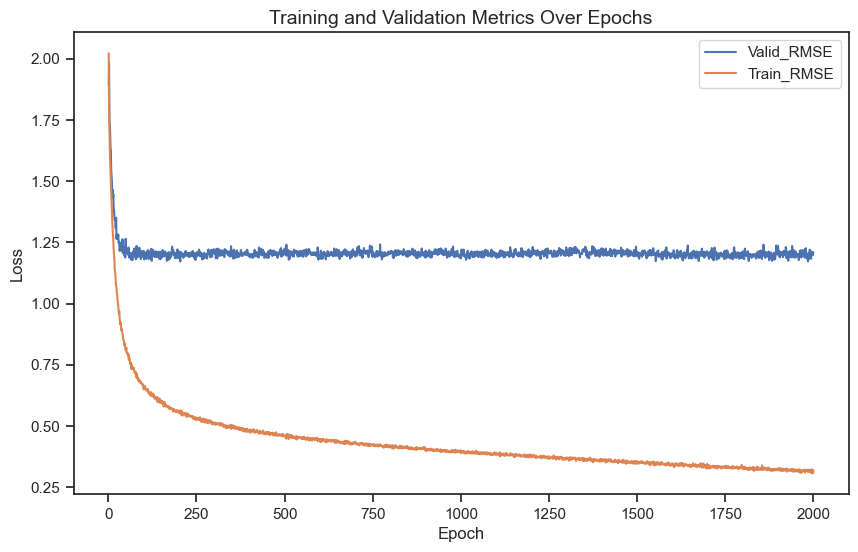

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [21]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.322258,0.322756,0.370143,0.370143,0.859167,0.926914,0.232914,NaN,1.206740,0.740079,0.740079,0.487195,0.704606,0.489051,0.487319,0.859169,1.204804
1996,1997,0.312181,0.312939,0.366691,0.366691,0.863451,0.929222,0.232148,NaN,1.203071,0.738685,0.738685,0.488754,0.705725,0.476593,0.489075,0.863453,1.201218
1997,1998,0.313443,0.314016,0.367349,0.367349,0.862981,0.928969,0.232598,NaN,1.206089,0.734888,0.734888,0.487472,0.708100,0.477169,0.488021,0.862981,1.203726
1998,1999,0.308055,0.307093,0.361238,0.361238,0.866002,0.930595,0.227096,NaN,1.197719,0.728305,0.728305,0.491028,0.708315,0.467570,0.491041,0.866002,1.195408
1999,2000,0.318432,0.318991,0.369162,0.369162,0.860810,0.927799,0.233920,NaN,1.209919,0.733216,0.733216,0.485844,0.707006,0.473949,0.486031,0.860811,1.207733


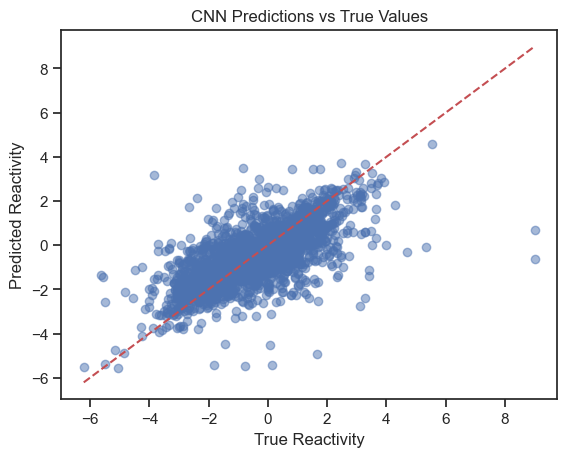

In [22]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("CNN Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()


In [15]:
import random
def predict_total_dataset(model_path, dataset_loader, device=None):
    """
    Calculate predictions for a dataset using a trained MLP model
    
    Args:
        model_path: Path to the saved model weights
        dataset_loader: DataLoader containing the dataset to predict on
        device: Torch device (will default to CUDA if available)
        
    Returns:
        Tuple of (predictions, labels)
    """
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Determine device if not provided
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get input dimensions from the first batch
    for batch in dataset_loader:
        mol_input_dim = batch['metabolite_features'].shape[1]
        protein_input_dim = batch['protein_features'].shape[1]
        break
    
    # Initialize the model
    model = MLPRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Generate predictions
    predictions = []
    labels = []
    
    with torch.no_grad():
        for batch in dataset_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            batch_labels = batch['label'].cpu().numpy()
            
            outputs = model(mol_features, protein_features)
            batch_preds = outputs.cpu().numpy()
            
            predictions.extend(batch_preds)
            labels.extend(batch_labels)
    
    return np.array(predictions), np.array(labels)

# Usage example:
model_path = os.path.join(r'./../../trained_model/random_split', 'MLP model.pt')
predictions, labels = predict_total_dataset(model_path, total_loader)
# Add predictions to your DataFrame
predictions

array([-0.03369749, -0.59516466, -0.9723102 , ..., -0.32113236,
       -0.7212705 , -0.7429604 ], dtype=float32)

In [16]:
import os
if os.path.exists('data_with_pred.joblib'):
    data_with_pred = joblib.load('data_with_pred.joblib')
else:
    data_with_pred = data.copy()

data_with_pred["MLP_pred"] = predictions
joblib.dump(data_with_pred, 'data_with_pred.joblib')
data_with_pred

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features,label,CAT_pred,CNN_pred,GBM_pred,LR_pred,MLP_pred
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126...",-1.303196,-0.664597,-1.227315,-0.456274,0.046098,-0.033697
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10...",-0.832509,-0.298970,-0.735445,-0.562968,-0.532851,-0.595165
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096...",-1.278754,-0.836997,-1.242703,-0.699874,-0.381774,-0.972310
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0....",2.124939,1.427049,0.659172,0.767883,0.932206,1.383574
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0....",1.408935,0.783579,1.170299,0.016693,0.681809,1.515772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-2.980003,-1.987372,-2.852437,-1.338873,-1.303237,-2.799196
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-0.462398,-1.656514,-1.883750,-1.248562,-1.116988,-2.273174
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-0.462398,-1.541640,-0.925752,-1.236483,-1.220809,-0.321132
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737...",-0.826075,-0.926702,-1.843686,-1.031461,-0.986014,-0.721271
